In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt 
import scipy.signal as sig
from scipy.integrate import solve_ivp
import pandas as pd
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter , butter , lfilter , freqz
from scipy import signal



In [3]:
path = '/Users/prathikprasad/Desktop/DataRepo Hook Load/12.25inch/'
df9= pd.read_csv(path+'BHA9.csv')

df9.head()


BHAs = [df9]

def time_to_seconds(t):
    h , m ,s  = map(int , t.split(':'))
    return h * 3600 + m * 60 +s

for df in BHAs:
    df['Time'] = df['HH:MM:SS'].apply(time_to_seconds)


In [4]:
# interpolating the block height

# 1. Interpolation
start_time = df9['Time'].min()
stop_time = df9['Time'].max()
time_resolution = 0.0001
time_new = np.arange(start_time , stop_time , time_resolution)

f = interp1d(df9['Time'] , df9['Block Height (feet)'] , kind = 'linear')
block_height_new = np.array(f(time_new))



def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b , a 

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y





df9['Block velocity'] = 0  # initialize with some default value
df9['Block velocity'].iloc[1:] = np.diff(df9['Block Height (feet)'])

df9['Block acceleration'] = 0  # initialize with some default value
df9['Block acceleration'].iloc[1:] = np.diff(df9['Block velocity']) 
df9['Block velocity'] = savgol_filter(df9['Block velocity'] , window_length=5 , polyorder=2)



/var/folders/83/x8n8gnb912j4pr6wmv03v7dr0000gn/T/ipykernel_31960/1543707925.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['Block velocity'].iloc[1:] = np.diff(df9['Block Height (feet)'])
/var/folders/83/x8n8gnb912j4pr6wmv03v7dr0000gn/T/ipykernel_31960/1543707925.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['Block acceleration'].iloc[1:] = np.diff(df9['Block velocity'])


In [5]:
cutoff = 0.2 
fs = 10000.0
order = 3
filtered_data = butter_lowpass_filter(block_height_new , cutoff , fs , order)




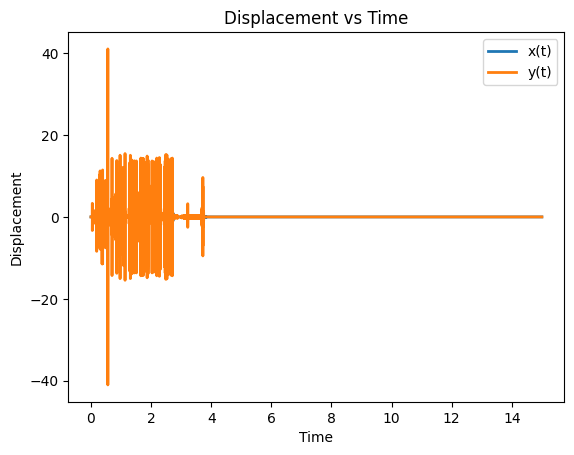

In [17]:
d = 17.5                                                       # feet 
A = np.pi * (d**2) / 2 
E = 2.282e9
l_drillstring = 1716.94 * 10                                   # Lenght of the drillstring element (feet)
l_bha =  97.6 *10                                              # Length of the bha element (feet)
K = E * A / l_drillstring                                      # Spring Constant
M = 132.63                                                     # Mass(lbs)
BF1 = 0.872                                                    # MW = 8.4 
BF2 =   0.863                                                  # MW = 9
g = 32.2                                                       # ft/s^2


rho_mud = 9                                                     # desnity of the drilling mud
Odp =   9.5                                                     # drillpipe outer diameter
idp =    3.167                                                  # drillpipe inner diameter
Ap =  np.pi * (((Odp**2)/4) -  ((idp**2)/4))                    # crossectional area of the annular space
Volp =    Ap * l_drillstring                                    # volume of the pipe


obh =     17.5                                                  # bha outer diameter 
ibh=      3.5                                                   # bha inner diameter 
Abh=      np.pi *  (((obh**2)/4) -  ((ibh**2)/4))               # area of the bha elements 
Volbh =   Abh * l_bha                                           # volume of the bha elements


total_volume = Volp + Volbh                                     # total volume of the drillstring

Wair = M * g                                                # Weight the drillstring
Fbuo = (1 - BF1) * Wair                                     # buoyant force exerted by the drilling mud on the drillstring
Weffective = Wair * BF1                                        # Effective weight of the drillstring
Meffective = Weffective / g                                      # effective mass of the drillstring


duration  = 15             # Finding the duration
dt= 0.0001                                                      # Define Time Step
num_point = int(duration/dt)                                  # Finding the number of points
C = 0.35                                                        # Damping Constant
t = np.arange(0, duration, dt)                # Define Time range
subset_df = df9[df9['Time'] <= 15]             # subsetting for the first ten seconds only
                                                          
y = np.zeros(len(t))

block_velocity_subset = subset_df['Block velocity'].values  
length_y = len(y)
step1_length = int(0.25 * length_y)
step2_length = length_y - step1_length

# print("this is the lenght of the step1: " , step1_length)
# print("this is the lenght of the lengthy: " , length_y)
# print("this is the lenght of the bh: " , df9['Block Height (feet)'])                      
y[:step1_length] = df9['Block acceleration'][:step1_length]
# y[step1_length:length_y] = df9['Block Height (feet)'][step1_length:length_y] 

x = np.zeros(len(t))
x[0]=0                          # Initial Condition
x[1]=df9['Block velocity'][2]




A1 = (C / dt) + (Meffective / dt ** 2) + K
A2 = (-2 * Meffective / dt ** 2) - (C / dt)
A3 = (Meffective / dt ** 2)
A4 = (C / dt) + K
A5 = (-C / dt)

for k in range(2, len(t)):
    x[k] = (1 / A1) * (A4 * y[k] + A5 * y[k - 1] - A2 * x[k - 1] - A3 * x[k - 2])

t = dt * np.arange(0, len(t))
# Plotting
plt.figure(1)
plt.plot(t, x, t, y, linewidth=2.0)
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.legend(['x(t)', 'y(t)'])
plt.title('Displacement vs Time')
# plt.xlim(1.35, 2)
plt.show()



think about how you can write C with respect to depth.

In [10]:
print(df9['Block Height (feet)'])
# print(block_height_new[:100])

0         63.27
1         63.27
2         63.27
3         63.27
4         63.27
          ...  
125536    63.51
125537    63.51
125538    63.51
125539    63.51
125540    63.51
Name: Block Height (feet), Length: 125541, dtype: float64
